In [2]:
import pandas as pd
import numpy as np
import os
import zipfile
import glob
import requests
import io

pd.options.display.max_columns=75

# Manufacturer and User Facility Device Experience Database - (MAUDE)


__MAUDE SEARCHABLE DATABASE:__
https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfmaude/search.cfm

Manufacturer and User Facility Device Experience (MAUDE)

MAUDE data represents reports of adverse events involving medical devices.

Each year, the FDA receives several hundred thousand medical device reports (MDRs) of suspected device-associated deaths, serious injuries and malfunctions. The FDA uses MDRs to monitor device performance, detect potential device-related safety issues, and contribute to benefit-risk assessments of these products. The MAUDE database houses MDRs submitted to the FDA by mandatory reporters 1 (manufacturers, importers and device user facilities) and voluntary reporters such as health care professionals, patients and consumers.

Although MDRs are a valuable source of information, this passive surveillance system has limitations, including the potential submission of incomplete, inaccurate, untimely, unverified, or biased data. In addition, the incidence or prevalence of an event cannot be determined from this reporting system alone due to potential under-reporting of events and lack of information about frequency of device use. Because of this, MDRs comprise only one of the FDA's several important postmarket surveillance data sources.

__Dataset Information:__
https://open.fda.gov/data/maude/ 

__Data Dictionary:__

https://www.fda.gov/medical-devices/mandatory-reporting-requirements-manufacturers-importers-and-device-user-facilities/manufacturer-and-user-facility-device-experience-database-maude

_Excerpt below:_

Master Event Data: A distinct master event data record will be present for each source reporting anevent. In other words, if a User Facility, Distributor, Manufacturer, and voluntary submitter all report an event, there will be four event records. These individual source records are related via the EVENT KEY. EVENT KEY is an internally-generated key which links multiple sources to a single event.

Device Data: Record Type 2 contains information related to the device(s) involved in the event.

Patient Data: Record Type 3 contains information related to the patient(s) involved in the event.

Text Data: Record Type 4 contains textual information from MEDWATCH Form Sections B5, H3, and H10.

All record types are linked via the MDR REPORT KEY.

For distributor reports which have had subsequent manufacturer reports, a special data element, MANUFACTURER LINK FLAG, will be set to 'Y'. In this case, the DISTRIBUTOR information (Section F on the master event data record) will be present; otherwise, these data elements will be blank.

In [3]:
# DataFrame to store the MAUDE Data

def maude_downloader(urls):
    """Downloads MAUDE files for data analysis.
    
    This will download the MAUDE file content, stream the bytes
    to uncompress and analyze. Will also append the list of zips
    into a single pandas DataFrame for analysis.
    
    Parameters:
        urls: list
            This is the list of urls from the MAUDE website that
            will be used for analysis.
    
    Returns:
        pandas DataFrame object
    
    """
    df = pd.DataFrame()
    # Relevant urls to download
    for url in urls:
        # Making the download request
        file = requests.get(url)
        # Accessing the file in the zip.
        with zipfile.ZipFile(io.BytesIO(file.content)) as zf:
            # Reading the filename
            for name in zf.namelist():
                # Opening the file, decoding and parsing for DataFrame
                # Skips over rows with errors.
                with zf.open(name) as myfile:
                    df = df.append(pd.read_csv(io.StringIO(myfile.read().decode('latin1')), delimiter='|', 
                                               error_bad_lines=False, warn_bad_lines=False, low_memory=False))
    return df

In [4]:
patient_urls = ['http://www.accessdata.fda.gov/MAUDE/ftparea/patientthru2019.zip', 'http://www.accessdata.fda.gov/MAUDE/ftparea/patientadd.zip']
patient = maude_downloader(patient_urls)

## Reviewing Patient Data



In [5]:
patient.shape

(9217661, 5)

In [6]:
# Mapping found on MAUDE website. Link above.
patient_mapping = """L - Life Threatening
H - Hospitalization
S - Disability
C - Congenital Anomaly
R - Required Intervention
O - Other
* - Invalid Data
U - Unknown
I - No Information
A - Not Applicable
D - Death""".split('\n')

# Mapped above string to dictionary.
patient_mapping = {i.split('-')[0].strip():i.split('-')[1].strip() for i in patient_mapping}

In [15]:
# Reviewing the data I found that multiple values appear in the SEQUENCE_NUMBER_OUTCOME field. But how often?

patient[patient.SEQUENCE_NUMBER_OUTCOME.str.contains(';').fillna(False)].head()

,MDR_REPORT_KEY,PATIENT_SEQUENCE_NUMBER,DATE_RECEIVED,SEQUENCE_NUMBER_TREATMENT,SEQUENCE_NUMBER_OUTCOME
8670,10040,1,07/12/1993,NaN,1. H; 2. O
8674,10062,1,08/10/1993,NaN,1. H; 2. O
8675,10063,1,08/13/1993,NaN,1. H; 2. L; 3. R
8677,10085,1,08/31/1993,NaN,1. H; 2. R
8681,10089,1,08/31/1993,NaN,1. O; 2. R


In [27]:
# How often does the SEQUENCE_NUMBER_OUTCOME contain multiple values? 
print(round((patient[patient.SEQUENCE_NUMBER_OUTCOME.str.contains(';').fillna(False)].shape[0]/patient.shape[0]) * 100 ,2), '% of the data contains multiple values in the SEQUENCE_NUMBER_OUTCOME field.')


7.94 % of the data contains multiple values in the SEQUENCE_NUMBER_OUTCOME field.


In [28]:
# Let's fix this. A couple are going on here. First, I'm creating an index based on the unique key 
# (MDR_REPORT_KEY) and the date. Next, I split the values by the semicolon and explode them. Exploding
# the data creates a new row with the split value. Similarly, splitting and expanding is necessary to 
# keep track of the sequence of outcomes but instead of creating more rows it expands the value into 
# a new column. Lastly, I renamed the columns for readability. 
df3 = patient.set_index(['MDR_REPORT_KEY', 'DATE_RECEIVED'])[['SEQUENCE_NUMBER_OUTCOME']].\
                        apply(lambda x: x.str.split(';').explode())['SEQUENCE_NUMBER_OUTCOME'].\
                        str.split('.', expand=True).\
                        rename(columns={0:'EVENT_SEQUENCE', 1:'PATIENT_OUTCOME'})

In [29]:
df3.PATIENT_OUTCOME = df3.PATIENT_OUTCOME.str.strip()

In [30]:
df3['OUTCOMES_TXT'] = df3['PATIENT_OUTCOME'].map(patient_mapping)

In [31]:
df3.reset_index(inplace=True)

In [32]:
df3.dtypes

MDR_REPORT_KEY      int64
DATE_RECEIVED      object
EVENT_SEQUENCE     object
PATIENT_OUTCOME    object
OUTCOMES_TXT       object
dtype: object

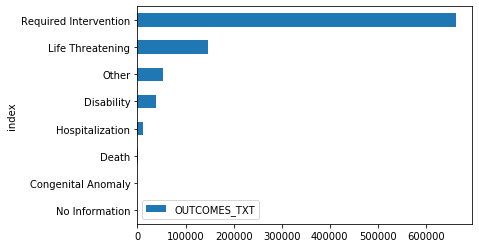

In [33]:
df3[df3.MDR_REPORT_KEY.duplicated()].OUTCOMES_TXT.value_counts(ascending=True).reset_index().plot.barh(x='index', y='OUTCOMES_TXT')

In [34]:
df3.OUTCOMES_TXT.value_counts()

Required Intervention    2352281
Other                    1188134
Hospitalization           754402
Life Threatening          240460
Death                     151993
Disability                 75124
Congenital Anomaly          2838
Invalid Data                 930
Not Applicable               130
No Information                 1
Name: OUTCOMES_TXT, dtype: int64

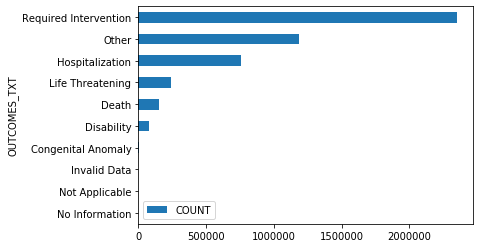

In [40]:
df3.OUTCOMES_TXT.value_counts(ascending=True).reset_index().rename(columns={'index':'OUTCOMES_TXT', 'OUTCOMES_TXT':'COUNT'}).plot.barh(x='OUTCOMES_TXT', y='COUNT')

In [42]:
df3.OUTCOMES_TXT=='Death'

0           False
1           False
2           False
3           False
4            True
            ...  
10129191    False
10129192    False
10129193    False
10129194    False
10129195    False
Name: OUTCOMES_TXT, Length: 10129196, dtype: bool

# MDRFOI & FOIDEV

In [ ]:
mdrfoi_urls = ['http://www.accessdata.fda.gov/MAUDE/ftparea/mdrfoi.zip', 'http://www.accessdata.fda.gov/MAUDE/ftparea/mdrfoithru2019.zip']
mdrfoi = maude_downloader(mdrfoi_urls)

foidev_urls = [
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2017.zip',
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2018.zip',
        'http://www.accessdata.fda.gov/MAUDE/ftparea/foidev2019.zip'
       ]
foidev = maude_downloader(foidev_urls)